In [1]:
#load libraries
import pandas as pd
import os as os
import numpy as np
import re
import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='jeremielamboley', api_key='Vl2N6wO66g1b8UXimcav')

# display option
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## scraped database from https://www.henleypassportindex.com

In [2]:
# scrapping script here: https://github.com/jeremielamboley/world-passport-power-rank-enriched/blob/master/henley_passport_index_data_collection.ipynb
df_visa_free = pd.read_csv('https://raw.githubusercontent.com/jeremielamboley/henley/master/henley_visa_free_11_01_2019.csv', encoding = "ISO-8859-1")

In [3]:
df_visa_free.rename(columns={'passport': 'passportfrom_alpha_2code'}, inplace=True)
df_visa_free.rename(columns={'to': 'countryto_alpha_2code'}, inplace=True)

In [4]:
df_visa_free.shape

(45173, 3)

In [5]:
df_visa_free['passportfrom_alpha_2code'].nunique()

198

In [6]:
df_visa_free['countryto_alpha_2code'].nunique()

226

In [7]:
# Let's consider the passport holders countries as a country which gives visa-free access
df_visa_free.loc[df_visa_free['passportfrom_alpha_2code'] == df_visa_free['countryto_alpha_2code'], 'visafree'] = 1

In [8]:
# visafree matrix preview
df_visa_free.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree
19911,WS,TJ,0
19834,PG,RE,0
6040,AL,LI,1
9616,TJ,IN,0
17434,ES,SR,1


In [9]:
# Nationals have visa free access to their own countries
df_visa_free[df_visa_free.passportfrom_alpha_2code == df_visa_free.countryto_alpha_2code].head()

,passportfrom_alpha_2code,countryto_alpha_2code,visafree
9,AM,AM,1
234,AG,AG,1
267,AO,AO,1
316,AR,AR,1
351,DZ,DZ,1


## List of world countries with ISO codes
### Source Wikipedia https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes
### Project by Radcliff https://gist.github.com/radcliff/f09c0f88344a7fcef373

In [10]:
df_iso = pd.read_csv('https://gist.githubusercontent.com/radcliff/f09c0f88344a7fcef373/raw/2753c482ad091c54b1822288ad2e4811c021d8ec/wikipedia-iso-country-codes.csv', encoding = "utf8")

In [11]:
df_iso.rename(columns={'English short name lower case': 'Country name'}, inplace=True)
df_iso.rename(columns={'Alpha-2 code': 'country_alpha_2code'}, inplace=True)
df_iso.rename(columns={'Alpha-3 code': 'country_alpha_3code'}, inplace=True)
df_iso.rename(columns={'Numeric code': 'country_numeric_code'}, inplace=True)
df_iso = df_iso.drop(['ISO 3166-2'], axis=1)

In [12]:
df_iso.shape

(246, 4)

In [13]:
df_iso.sample(5)

,Country name,country_alpha_2code,country_alpha_3code,country_numeric_code
70,Faroe Islands,FO,FRO,234
138,Mauritania,MR,MRT,478
230,United Arab Emirates,AE,ARE,784
187,Saint Martin (French part),MF,MAF,663
94,Heard Island and McDonald Islands,HM,HMD,334


## Add the Regions, Standard country or area codes for statistical use (M49)
## https://unstats.un.org/unsd/methodology/m49/overview/

In [14]:
df_regions = pd.read_csv('https://raw.githubusercontent.com/jeremielamboley/world-passport-power-rank-enriched/master/UNSD-M49-25-01-2019.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=0)

In [15]:
df_regions.sample(5)

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Developed / Developing Countries
98,1,World,19.0,Americas,419.0,Latin America and the Caribbean,5.0,South America,Bouvet Island,74,BVT,NaN,NaN,NaN,Developing
195,1,World,150.0,Europe,39.0,Southern Europe,NaN,NaN,Albania,8,ALB,NaN,NaN,NaN,Developed
242,1,World,9.0,Oceania,61.0,Polynesia,NaN,NaN,Niue,570,NIU,NaN,NaN,x,Developing
219,1,World,150.0,Europe,155.0,Western Europe,NaN,NaN,Switzerland,756,CHE,NaN,NaN,NaN,Developed
187,1,World,150.0,Europe,154.0,Northern Europe,NaN,NaN,Ireland,372,IRL,NaN,NaN,NaN,Developed


In [16]:
#df_regions['Developed / Developing Countries'] = df_regions.loc[df_regions['Least Developed Countries (LDC)'] == 'x','Developed / Developing Countries'] = 'Least Developed'
df_regions['Developed / Developing Countries'] = np.where(df_regions['Least Developed Countries (LDC)'] == 'x', 'Least Developed', df_regions['Developed / Developing Countries'])

In [17]:
df_regions.sample(5)

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Developed / Developing Countries
12,1,World,2.0,Africa,202.0,Sub-Saharan Africa,14.0,Eastern Africa,Ethiopia,231,ETH,x,x,NaN,Least Developed
145,1,World,142.0,Asia,34.0,Southern Asia,NaN,NaN,Iran (Islamic Republic of),364,IRN,NaN,NaN,NaN,Developing
142,1,World,142.0,Asia,34.0,Southern Asia,NaN,NaN,Bangladesh,50,BGD,x,NaN,NaN,Least Developed
183,1,World,150.0,Europe,154.0,Northern Europe,NaN,NaN,Estonia,233,EST,NaN,NaN,NaN,Developed
209,1,World,150.0,Europe,39.0,Southern Europe,NaN,NaN,Spain,724,ESP,NaN,NaN,NaN,Developed


In [18]:
df_regions = df_regions[['ISO-alpha3 Code','Region Name','Sub-region Name','Developed / Developing Countries']]
df_regions = df_regions.rename(columns={'ISO-alpha3 Code':'country_alpha_3code'})
df_regions

,country_alpha_3code,Region Name,Sub-region Name,Developed / Developing Countries
0,DZA,Africa,Northern Africa,Developing
1,EGY,Africa,Northern Africa,Developing
2,LBY,Africa,Northern Africa,Developing
3,MAR,Africa,Northern Africa,Developing
4,SDN,Africa,Northern Africa,Least Developed
5,TUN,Africa,Northern Africa,Developing
6,ESH,Africa,Northern Africa,Developing
7,IOT,Africa,Sub-Saharan Africa,Developing
8,BDI,Africa,Sub-Saharan Africa,Least Developed
9,COM,Africa,Sub-Saharan Africa,Least Developed


## GDP per countries in USD, 2016, from the United Nations Statistics Division
### Source: http://data.un.org/

In [19]:
df_GDP_UN = pd.read_csv('http://data.un.org/_Docs/SYB/CSV/SYB61_T13_GDP%20and%20GDP%20Per%20Capita.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=1)

In [20]:
# filter the data to GDP in 2016
df_GDP_UN = df_GDP_UN[df_GDP_UN['Series'] == 'GDP in current prices (millions of US dollars)']
df_GDP_UN = df_GDP_UN[df_GDP_UN.Year == 2016]

In [21]:
# Organize the data
df_GDP_UN['Value'] = df_GDP_UN['Value'].str.replace(',', '')
df_GDP_UN['Value'] = df_GDP_UN['Value'].astype(int)
# Renaming columns
df_GDP_UN.rename(columns={'Region/Country/Area': 'country_numeric_code'}, inplace=True)
df_GDP_UN.rename(columns={'Value': 'UN_GDP_currentPrices2016'}, inplace=True)
# Convert GDP from millions to billions
df_GDP_UN['UN_GDP_currentPrices2016_billions'] = df_GDP_UN['UN_GDP_currentPrices2016'] / 1000

In [22]:
df_GDP_UN.shape

(242, 8)

In [23]:
df_GDP_UN.sample(5)

,country_numeric_code,Unnamed: 1,Year,Series,UN_GDP_currentPrices2016,Footnotes,Source,UN_GDP_currentPrices2016_billions
2729,246,Finland,2016,GDP in current prices (millions of US dollars),238503,NaN,"United Nations Statistics Division, New York, ...",238.503
2489,218,Ecuador,2016,GDP in current prices (millions of US dollars),98010,NaN,"United Nations Statistics Division, New York, ...",98.010
814,61,Polynesia,2016,GDP in current prices (millions of US dollars),6969,NaN,"United Nations Statistics Division, New York, ...",6.969
5096,498,Republic of Moldova,2016,GDP in current prices (millions of US dollars),6773,NaN,"United Nations Statistics Division, New York, ...",6.773
1334,56,Belgium,2016,GDP in current prices (millions of US dollars),467955,NaN,"United Nations Statistics Division, New York, ...",467.955


In [24]:
df_GDP_UN = df_GDP_UN[['country_numeric_code','UN_GDP_currentPrices2016_billions']]

### World total GDP for 2016 to get a % of coverage per passport

In [25]:
# country code = 1 for the world aggregate
df_GDP_UN['UN_World_GDP_percent'] = df_GDP_UN['UN_GDP_currentPrices2016_billions'] / df_GDP_UN[df_GDP_UN['country_numeric_code'] == 1].iloc[0,1]

In [26]:
df_GDP_UN.sample(5)

,country_numeric_code,UN_GDP_currentPrices2016_billions,UN_World_GDP_percent
3693,418,15.806,0.000209
146,17,225.212,0.002977
6328,826,2647.899,0.035002
3313,364,425.403,0.005623
4985,620,204.837,0.002708


# Population and surface, 2015, from the United Nations Statistics Division

### Source: http://data.un.org/

In [27]:
df_population_surface_UN = pd.read_csv('http://data.un.org/_Docs/SYB/CSV/SYB61_T02_Population,%20Surface%20Area%20and%20Density.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=1)

In [28]:
# filter the data to GDP in 2015
df_population_surface_UN = df_population_surface_UN[(df_population_surface_UN['Series'] == 'Population mid-year estimates (millions)') | (df_population_surface_UN['Series'] == 'Surface area (thousand km2)')]
df_population_surface_UN = df_population_surface_UN[df_population_surface_UN['Year'] == 2015]

In [29]:
# Organize the data
df_population_surface_UN['Value'] = df_population_surface_UN['Value'].str.replace(',', '')
df_population_surface_UN['Value'] = df_population_surface_UN['Value'].astype(float)

In [30]:
df_population_surface_UN = df_population_surface_UN[['Region/Country/Area','Series','Value']]
df_population_surface_UN.rename(columns={'Region/Country/Area': 'country_numeric_code'}, inplace=True)

In [31]:
# pivot and un-pivot
df_population_surface_UN = df_population_surface_UN.pivot(index='country_numeric_code', columns='Series', values='Value')
df_population_surface_UN = pd.DataFrame(df_population_surface_UN.to_records())

In [32]:
# get the world total for population and surface
df_population_UN_world = df_population_surface_UN[(df_population_surface_UN.country_numeric_code == 1)].iloc[0,1]
df_surface_UN_world = df_population_surface_UN[(df_population_surface_UN.country_numeric_code == 1)].iloc[0,2]

In [33]:
# World Population mid-year estimates 7383 millions, 2015
# Source: United Nations Statistics Division, New York, World Population Prospects: The 2017 Revision, last accessed June 2017.
df_population_surface_UN['UN_population_Value_2015_percent'] = (df_population_surface_UN['Population mid-year estimates (millions)'] / df_population_UN_world)

In [34]:
df_population_surface_UN['Surface_area_convered_percent'] = (df_population_surface_UN['Surface area (thousand km2)'] / df_surface_UN_world)

In [35]:
df_population_surface_UN.sample(5)

,country_numeric_code,Population mid-year estimates (millions),Surface area (thousand km2),UN_population_Value_2015_percent,Surface_area_convered_percent
184,585,0.02,0.0,0.000003,0.000000
56,132,0.53,4.0,0.000072,0.000029
16,21,356.00,21776.0,0.048219,0.159927
22,32,43.42,2780.0,0.005881,0.020417
156,480,1.26,2.0,0.000171,0.000015


# Unesco World Heritage list 

### https://whc.unesco.org/en/syndication

In [36]:
# Fetch the data from the Unesco website
unesco = pd.read_excel('https://whc.unesco.org/en/list/xls/whc-sites-2018.xls', encoding="Windows-1252",header=0)
unesco = unesco.reindex(['name_en', 'iso_code'], axis="columns")

In [37]:
# check the shape
unesco.shape

(1092, 2)

In [38]:
# Some values are comma separated and need to be reformated
unesco.tail(5)

,name_en,iso_code
1087,Prehistoric Rock Art Sites in the Côa Valley a...,"pt,es"
1088,Uvs Nuur Basin,"ru,mn"
1089,Landscapes of Dauria,"ru,mn"
1090,Heritage of Mercury. Almadén and Idrija,"si,es"
1091,Mosi-oa-Tunya / Victoria Falls,"zm,zw"


In [39]:
# Split the values
unesco = pd.concat([unesco['name_en'], unesco['iso_code'].str.split(',', expand=True)], axis=1)

unesco2 = []
for i in range(0,11):
    temp = unesco.loc[:,['name_en',i]]
    temp.columns = ['name_en','countryto_alpha_2code']
    unesco2.append(temp)
unesco2 = pd.concat(unesco2, ignore_index=True)

# Remove empty values
unesco2 = unesco2.replace(to_replace='None', value=np.nan).dropna().reset_index(drop=True)
# preview
unesco2.sample(5)

,name_en,countryto_alpha_2code
771,Baekje Historic Areas,kr
572,Thimlich Ohinga Archaeological Site,ke
720,Chan Chan Archaeological Zone,pe
988,Maritime Greenwich,gb
860,Archaeological Ensemble of Mérida,es


In [40]:
# create a pivot table
unesco_pivot = pd.pivot_table(unesco2,index=['countryto_alpha_2code'], aggfunc='count')
unesco_pivot = pd.DataFrame(unesco_pivot.to_records())
unesco_pivot = unesco_pivot.rename(columns = {'name_en' :'unesco_total_sites'})
unesco_pivot = unesco_pivot.sort_values('unesco_total_sites',ascending=False)

In [41]:
# Count the total of world unesco sites
unesco_total_sites = unesco_pivot['unesco_total_sites'].sum()
# create the % of sites located in each country
unesco_pivot['unesco_total_sites_percent'] = (unesco_pivot['unesco_total_sites'] / unesco_total_sites)

In [42]:
# change to uppercase
unesco_pivot['countryto_alpha_2code'] = unesco_pivot['countryto_alpha_2code'].str.upper()

In [43]:
unesco_pivot.sample(5)

,countryto_alpha_2code,unesco_total_sites,unesco_total_sites_percent
161,VN,8,0.006861
26,CF,2,0.001715
94,MA,9,0.007719
58,GM,2,0.001715
80,KI,1,0.000858


## Intersect df_iso and df_regions

In [44]:
df_iso = pd.merge(df_iso, df_regions, how='left', on='country_alpha_3code')
df_iso.sample(5)

,Country name,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries
175,Poland,PL,POL,616,Europe,Eastern Europe,Developed
186,Saint Lucia,LC,LCA,662,Americas,Latin America and the Caribbean,Developing
218,Timor-Leste,TL,TLS,626,Asia,South-eastern Asia,Least Developed
182,Rwanda,RW,RWA,646,Africa,Sub-Saharan Africa,Least Developed
70,Faroe Islands,FO,FRO,234,Europe,Northern Europe,Developed


## Intersect df_visa_free and df_iso on 'country to'

In [45]:
# copy df_visa_free, rename the columns from centadata and hauntedhouse
df_visa_free2 = df_visa_free.copy()

In [46]:
df_visa_free2.rename(columns={'countryto_alpha_2code': 'country_alpha_2code'}, inplace=True)

In [47]:
# Intersect on 'countryto_alpha_2code'
df = pd.merge(df_visa_free2, df_iso, on=['country_alpha_2code'], how='left')

In [48]:
df.rename(columns={'country_alpha_2code': 'countryto_alpha_2code'}, inplace=True)
df.rename(columns={'Country name': 'countryto_Country_name'}, inplace=True)
df.rename(columns={'country_alpha_3code': 'countryto_country_alpha_3code'}, inplace=True)
df.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)

In [49]:
df['passportfrom_alpha_2code'].nunique()

198

In [50]:
df['countryto_alpha_2code'].nunique()

226

In [51]:
df.sample(10)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries
7785,TM,KE,1,Kenya,KEN,404.0,Africa,Sub-Saharan Africa,Developing
7085,TV,HU,1,Hungary,HUN,348.0,Europe,Eastern Europe,Developed
12319,WS,CM,0,Cameroon,CMR,120.0,Africa,Sub-Saharan Africa,Developing
40939,FI,PS,1,"Palestinian Territory, Occupied",PSE,275.0,Asia,Western Asia,Developing
32076,GQ,AF,0,Afghanistan,AFG,4.0,Asia,Southern Asia,Least Developed
18366,MD,AM,1,Armenia,ARM,51.0,Asia,Western Asia,Developing
23975,ME,MY,0,Malaysia,MYS,458.0,Asia,South-eastern Asia,Developing
25502,MZ,SM,0,San Marino,SMR,674.0,Europe,Southern Europe,Developed
17228,NE,GM,1,Gambia,GMB,270.0,Africa,Sub-Saharan Africa,Least Developed
26269,MM,TH,1,Thailand,THA,764.0,Asia,South-eastern Asia,Developing


## Intersect df_visa_free and df_iso on 'passport'

In [52]:
df_iso.rename(columns={'country_alpha_2code': 'passportfrom_alpha_2code'}, inplace=True)

In [53]:
# Intersect on 'passportfrom_alpha_2code'
df = pd.merge(df, df_iso, on=['passportfrom_alpha_2code'], how='left')

In [54]:
df_iso.rename(columns={'passportfrom_alpha_2code': 'country_alpha_2code'}, inplace=True)

In [55]:
df.rename(columns={'Country name': 'passportfrom_Country_name'}, inplace=True)

In [56]:
df = df.drop(['country_alpha_3code'], axis=1)
df = df.drop(['country_numeric_code'], axis=1)

## Intersect df and df_GDP_UN

In [57]:
df_GDP_UN2 = df_GDP_UN.copy()
df_GDP_UN2.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)

In [58]:
df2 = pd.merge(df, df_GDP_UN2, on=['countryto_country_numeric_code'], how='left')

In [59]:
df2.rename(columns={'UN_GDP_currentPrices2016_billions': 'countryto_UN_GDP_currentPrices2016'}, inplace=True)

In [60]:
df2.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,Region Name_x,Sub-region Name_x,Developed / Developing Countries_x,passportfrom_Country_name,Region Name_y,Sub-region Name_y,Developed / Developing Countries_y,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent
22985,NR,NC,1,New Caledonia,NCL,540.0,Oceania,Melanesia,Developing,Nauru,Oceania,Micronesia,Developing,9.446,0.000125
28658,FM,ZW,1,Zimbabwe,ZWE,716.0,Africa,Sub-Saharan Africa,Developing,"Micronesia, Federated States of",Oceania,Micronesia,Developing,16.124,0.000213
37889,AU,BJ,1,Benin,BEN,204.0,Africa,Sub-Saharan Africa,Least Developed,Australia,Oceania,Australia and New Zealand,Developed,8.894,0.000118
7421,UA,MT,1,Malta,MLT,470.0,Europe,Southern Europe,Developed,Ukraine,Europe,Eastern Europe,Developed,10.999,0.000145
4351,UA,CK,1,Cook Islands,COK,184.0,Oceania,Polynesia,Developing,Ukraine,Europe,Eastern Europe,Developed,0.290,0.000004


## Intersect df2 and df_population_UN

In [61]:
df_population_UN2 = df_population_surface_UN.copy()
df_population_UN2.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)

In [62]:
df3 = pd.merge(df2, df_population_UN2, on=['countryto_country_numeric_code'], how='left')

In [63]:
#df3.rename(columns={'UN_population_Value_2015_millions': 'countryto_UN_population_Value_2015_millions'}, inplace=True)
df3.rename(columns={'Population mid-year estimates (millions)': 'countryto_UN_population_Value_2015_millions'}, inplace=True)
df3.rename(columns={'Surface area (thousand km2)': 'countryto_Surface area (thousand km2)'}, inplace=True)

In [64]:
df3.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,Region Name_x,Sub-region Name_x,Developed / Developing Countries_x,passportfrom_Country_name,Region Name_y,Sub-region Name_y,Developed / Developing Countries_y,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,countryto_Surface area (thousand km2),UN_population_Value_2015_percent,Surface_area_convered_percent
44515,BO,TH,0,Thailand,THA,764.0,Asia,South-eastern Asia,Developing,"Bolivia, Plurinational State of",Americas,Latin America and the Caribbean,Developing,407.026,0.005380,68.66,513.0,0.009300,0.003768
6884,UZ,LV,0,Latvia,LVA,428.0,Europe,Northern Europe,Developed,Uzbekistan,Asia,Central Asia,Developing,27.573,0.000364,1.99,65.0,0.000270,0.000477
24027,KI,CO,0,Colombia,COL,170.0,Americas,Latin America and the Caribbean,Developing,Kiribati,Oceania,Micronesia,Least Developed,282.463,0.003734,48.23,1142.0,0.006533,0.008387
24068,NR,QA,0,Qatar,QAT,634.0,Asia,Western Asia,Developing,Nauru,Oceania,Micronesia,Developing,152.452,0.002015,2.48,12.0,0.000336,0.000088
18527,KP,LB,0,Lebanon,LBN,422.0,Asia,Western Asia,Developing,"Korea, Democratic People's Republic of",Asia,Eastern Asia,Developing,50.458,0.000667,5.85,10.0,0.000792,0.000073


## Intersect df3 and unesco_pivot

In [65]:
unesco_pivot2 = unesco_pivot.copy()

In [66]:
df4 = pd.merge(df3, unesco_pivot2, on=['countryto_alpha_2code'], how='left')

In [67]:
df4.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,Region Name_x,Sub-region Name_x,Developed / Developing Countries_x,passportfrom_Country_name,Region Name_y,Sub-region Name_y,Developed / Developing Countries_y,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,countryto_Surface area (thousand km2),UN_population_Value_2015_percent,Surface_area_convered_percent,unesco_total_sites,unesco_total_sites_percent
9329,SI,CM,0,Cameroon,CMR,120.0,Africa,Sub-Saharan Africa,Developing,Slovenia,Europe,Southern Europe,Developed,32.217,4.258755e-04,22.83,476.0,0.003092,0.003496,2.0,0.001715
21223,MG,AZ,0,Azerbaijan,AZE,31.0,Asia,Western Asia,Developing,Madagascar,Africa,Sub-Saharan Africa,Least Developed,37.847,5.002983e-04,9.62,87.0,0.001303,0.000639,2.0,0.001715
2932,AD,IR,1,"Iran, Islamic Republic of",IRN,364.0,Asia,Southern Asia,Developing,Andorra,Europe,Southern Europe,Developed,425.403,5.623389e-03,79.36,1629.0,0.010749,0.011964,23.0,0.019726
22819,PE,TV,1,Tuvalu,TUV,798.0,Oceania,Polynesia,Least Developed,Peru,Americas,Latin America and the Caribbean,Developing,0.037,4.891018e-07,0.01,0.0,0.000001,0.000000,NaN,NaN
25163,ML,LR,1,Liberia,LBR,430.0,Africa,Sub-Saharan Africa,Least Developed,Mali,Africa,Sub-Saharan Africa,Least Developed,2.757,3.644470e-05,4.50,111.0,0.000610,0.000815,NaN,NaN


## Reordering the columns

In [68]:
df4 = df4.reset_index(drop=True)
cols = df4.columns.tolist()
cols

['passportfrom_alpha_2code',
 'countryto_alpha_2code',
 'visafree',
 'countryto_Country_name',
 'countryto_country_alpha_3code',
 'countryto_country_numeric_code',
 'Region Name_x',
 'Sub-region Name_x',
 'Developed / Developing Countries_x',
 'passportfrom_Country_name',
 'Region Name_y',
 'Sub-region Name_y',
 'Developed / Developing Countries_y',
 'countryto_UN_GDP_currentPrices2016',
 'UN_World_GDP_percent',
 'countryto_UN_population_Value_2015_millions',
 'countryto_Surface area (thousand km2)',
 'UN_population_Value_2015_percent',
 'Surface_area_convered_percent',
 'unesco_total_sites',
 'unesco_total_sites_percent']

In [69]:
df4 = df4[['passportfrom_alpha_2code','passportfrom_Country_name','countryto_alpha_2code','countryto_Country_name','countryto_country_alpha_3code', 'countryto_country_numeric_code','countryto_UN_GDP_currentPrices2016','UN_World_GDP_percent', 'countryto_UN_population_Value_2015_millions','UN_population_Value_2015_percent','countryto_Surface area (thousand km2)','Surface_area_convered_percent','unesco_total_sites','unesco_total_sites_percent','visafree']]

In [70]:
df4['passportfrom_alpha_2code'].nunique()

198

In [71]:
df4.head(5)

,passportfrom_alpha_2code,passportfrom_Country_name,countryto_alpha_2code,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),Surface_area_convered_percent,unesco_total_sites,unesco_total_sites_percent,visafree
0,AM,Armenia,AF,Afghanistan,AFG,4.0,20.235,0.000267,33.74,0.004570,653.0,0.004796,2.0,0.001715,0
1,AM,Armenia,AL,Albania,ALB,8.0,11.864,0.000157,2.92,0.000396,29.0,0.000213,3.0,0.002573,1
2,AM,Armenia,DZ,Algeria,DZA,12.0,159.049,0.002102,39.87,0.005400,2382.0,0.017494,7.0,0.006003,0
3,AM,Armenia,AS,American Samoa,ASM,16.0,NaN,NaN,0.06,0.000008,0.0,0.000000,NaN,NaN,0
4,AM,Armenia,AD,Andorra,AND,20.0,2.858,0.000038,0.08,0.000011,0.0,0.000000,1.0,0.000858,0


## Pandas pivot_table 'passport FROM'

In [72]:
df_pivot = pd.pivot_table(df4[df4.visafree == 1],index='passportfrom_Country_name',values=['countryto_UN_GDP_currentPrices2016','UN_World_GDP_percent','countryto_UN_population_Value_2015_millions','UN_population_Value_2015_percent','countryto_Surface area (thousand km2)','Surface_area_convered_percent','unesco_total_sites','unesco_total_sites_percent','visafree'], aggfunc=np.sum, margins=False,dropna=True)
df_pivot.sort_values('visafree', ascending=False)
df_pivot.head(5)

,Surface_area_convered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree
passportfrom_Country_name,,,,,,,,,
Afghanistan,0.043228,0.006096,0.053354,5886.0,461.147,393.91,41.0,0.035163,31
Albania,0.235925,0.304711,0.269534,32124.0,23051.078,1989.97,640.0,0.548885,116
Algeria,0.126034,0.040480,0.132256,17161.0,3062.282,976.45,164.0,0.140652,51
Andorra,0.541803,0.758506,0.424193,73773.0,57380.122,3131.82,916.0,0.785592,170
Angola,0.123030,0.044224,0.153492,16752.0,3345.458,1133.23,141.0,0.120926,50


## Turn the pivot table in a Data frame

In [73]:
df_pivot_flattened = pd.DataFrame(df_pivot.to_records())
df_pivot_flattened.sample(5)

,passportfrom_Country_name,Surface_area_convered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree
106,Malawi,0.118763,0.055873,0.161839,16171.0,4226.747,1194.86,169.0,0.144940,72
139,Peru,0.449553,0.373666,0.362350,61212.0,28267.442,2675.23,786.0,0.674099,135
81,Ireland,0.576622,0.750867,0.430073,78514.0,56802.234,3175.23,918.0,0.787307,185
172,"Taiwan, Province of China",0.473392,0.825559,0.523988,64458.0,62452.570,3868.61,816.0,0.699828,150
54,Eritrea,0.064467,0.021901,0.088683,8778.0,1656.767,654.75,84.0,0.072041,39


## Pandas pivot_table 'passport TO'

In [74]:
df_pivot2 = pd.pivot_table(df4[df4.visafree == 1],index='countryto_Country_name',values=['visafree'], aggfunc=np.sum, margins=False,dropna=True)
df_pivot_flattened2 = pd.DataFrame(df_pivot2.to_records())
df_pivot_flattened2.rename(columns = {'countryto_Country_name':'passportfrom_Country_name','visafree':'visafreeTO'}, inplace=True)
df_pivot_flattened2

,passportfrom_Country_name,visafreeTO
0,Afghanistan,1
1,Albania,90
2,Algeria,8
3,American Samoa,41
4,Andorra,94
5,Angola,12
6,Anguilla,84
7,Antigua and Barbuda,106
8,Argentina,88
9,Armenia,134


In [75]:
df_pivot_flattened['Surface_Rank'] = df_pivot_flattened['countryto_Surface area (thousand km2)'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['GDP_Rank'] = df_pivot_flattened['countryto_UN_GDP_currentPrices2016'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['Population_Rank'] = df_pivot_flattened['countryto_UN_population_Value_2015_millions'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['visafree_countries_Rank'] = df_pivot_flattened['visafree'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['unesco_total_sites_Rank'] = df_pivot_flattened['unesco_total_sites'].rank(method='min', ascending=False).astype(int)

## Calculate the overall ranking

In [76]:
df_pivot_flattened['Overall_ranking_calculation'] = df_pivot_flattened[['visafree_countries_Rank','GDP_Rank','Surface_Rank','Population_Rank','unesco_total_sites_Rank']].sum(axis=1)

In [77]:
df_pivot_flattened['New_Overall_ranking'] = df_pivot_flattened['Overall_ranking_calculation'].rank(method='min', ascending=True).astype(int)

## Create a new column Gain/loss in ranking

In [78]:
df_pivot_flattened['gain-loss'] = df_pivot_flattened['visafree_countries_Rank'] - df_pivot_flattened['New_Overall_ranking']

In [79]:
df_pivot_flattened.sample(5)

,passportfrom_Country_name,Surface_area_convered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,Surface_Rank,GDP_Rank,Population_Rank,visafree_countries_Rank,unesco_total_sites_Rank,Overall_ranking_calculation,New_Overall_ranking,gain-loss
152,Sao Tome and Principe,0.108951,0.053027,0.168999,14835.0,4011.437,1247.72,151.0,0.129503,59,166,142,149,143,150,750,155,-12
3,Andorra,0.541803,0.758506,0.424193,73773.0,57380.122,3131.82,916.0,0.785592,170,30,20,41,42,28,161,30,12
41,Croatia,0.417003,0.475386,0.349349,56780.0,35962.427,2579.25,848.0,0.727273,169,69,59,72,46,52,298,58,-12
181,Turkey,0.312885,0.231431,0.291183,42603.0,17507.517,2149.81,420.0,0.360206,112,91,99,91,95,96,472,96,-1
112,Mauritania,0.138614,0.049626,0.161499,18874.0,3754.186,1192.35,160.0,0.137221,59,134,152,157,143,140,726,145,-2


## Reorder the columns

In [80]:
df_pivot_flattened = df_pivot_flattened[['passportfrom_Country_name',
                                         'New_Overall_ranking',
                                         'gain-loss',
                                         'visafree',
                                         'visafree_countries_Rank',
                                         'countryto_UN_GDP_currentPrices2016',
                                         'GDP_Rank',
                                         'UN_World_GDP_percent',
                                         'countryto_UN_population_Value_2015_millions',
                                         'Population_Rank',
                                         'UN_population_Value_2015_percent',
                                         'countryto_Surface area (thousand km2)',
                                         'Surface_Rank',
                                         'Surface_area_convered_percent',
                                         'unesco_total_sites',
                                         'unesco_total_sites_percent',
                                         'unesco_total_sites_Rank',
                                         'Overall_ranking_calculation']]

## New Ranking 

In [81]:
df_iso.rename(columns={'Country name': 'passportfrom_Country_name'}, inplace=True)
df_pivot_flattened = pd.merge(df_pivot_flattened, df_iso, how='left', on='passportfrom_Country_name')

In [82]:
df_pivot_flattened = pd.merge(df_pivot_flattened, df_pivot_flattened2, how='left', on='passportfrom_Country_name')

In [83]:
df_pivot_flattened['visaFreeRatio'] = df_pivot_flattened['visafreeTO'] / df_pivot_flattened['visafree']

In [84]:
# Re-order and format the values
df_pivot_flattened.sort_values('New_Overall_ranking',ascending=True, inplace=True)
df_pivot_flattened = df_pivot_flattened.reset_index(drop=True)
df_pivot_flattened.style.format({
    'UN_World_GDP_percent': '{:.2%}'.format,
    'UN_population_Value_2015_percent': '{:.2%}'.format,
    'Surface_area_convered_percent': '{:.2%}'.format,
    'unesco_total_sites_percent': '{:.2%}'.format
    })

,passportfrom_Country_name,New_Overall_ranking,gain-loss,visafree,visafree_countries_Rank,countryto_UN_GDP_currentPrices2016,GDP_Rank,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,Population_Rank,UN_population_Value_2015_percent,countryto_Surface area (thousand km2),Surface_Rank,Surface_area_convered_percent,unesco_total_sites,unesco_total_sites_percent,unesco_total_sites_Rank,Overall_ranking_calculation,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries,visafreeTO,visaFreeRatio
0,Japan,1,0,191,1,69726.3,1,92.17%,5923.63,1,80.23%,86657,4,63.64%,1024,87.82%,1,8,JP,JPN,392,Asia,Eastern Asia,Developed,68,0.356021
1,Singapore,2,0,190,2,69078.8,2,91.32%,4752.05,3,64.36%,90972,2,66.81%,1009,86.54%,3,12,SG,SGP,702,Asia,South-eastern Asia,Developing,164,0.863158
2,"Korea, Republic of",3,-1,190,2,61527.8,6,81.33%,4877.4,2,66.06%,100405,1,73.74%,1017,87.22%,2,13,KR,KOR,410,Asia,Eastern Asia,Developing,111,0.584211
3,France,4,0,189,4,57942.3,7,76.59%,3378.6,16,45.76%,80242,9,58.93%,951,81.56%,5,41,FR,FRA,250,Europe,Western Europe,Developed,94,0.497354
4,Germany,5,-1,189,4,57885.7,8,76.52%,3350.6,17,45.38%,81357,8,59.75%,951,81.56%,5,42,DE,DEU,276,Europe,Western Europe,Developed,94,0.497354
5,Denmark,6,0,188,6,57874.5,9,76.50%,3347.62,18,45.34%,79793,10,58.60%,946,81.13%,7,50,DK,DNK,208,Europe,Northern Europe,Developed,94,0.5
6,Finland,6,0,188,6,57874.5,9,76.50%,3347.62,18,45.34%,79793,10,58.60%,946,81.13%,7,50,FI,FIN,246,Europe,Northern Europe,Developed,94,0.5
7,Sweden,6,0,188,6,57874.5,9,76.50%,3347.62,18,45.34%,79793,10,58.60%,946,81.13%,7,50,SE,SWE,752,Europe,Northern Europe,Developed,94,0.5
8,Italy,6,0,188,6,57874.5,9,76.50%,3347.62,18,45.34%,79793,10,58.60%,946,81.13%,7,50,IT,ITA,380,Europe,Southern Europe,Developed,94,0.5
9,San Marino,10,36,169,46,68521.7,3,90.58%,4481.94,4,60.71%,82795,7,60.81%,959,82.25%,4,64,SM,SMR,674,Europe,Southern Europe,Developed,94,0.556213


In [85]:
# Export to CSV
df_pivot_flattened.to_csv('ranking.csv')

## Biggest winners and losers

In [86]:
df_rankgainloss = df_pivot_flattened[['passportfrom_Country_name','gain-loss']].sort_values('gain-loss', ascending=False, inplace=False)
df_rankgainloss.style.format({
    'UN_World_GDP_percent': '{:.2%}'.format,
    'UN_population_Value_2015_percent': '{:.2%}'.format,
    'Surface_area_convered_percent': '{:.2%}'.format,
    'unesco_total_sites_percent': '{:.2%}'.format
    })

,passportfrom_Country_name,gain-loss
146,Nepal,41
9,San Marino,36
77,Belarus,34
58,Bosnia and Herzegovina,32
16,Brunei Darussalam,31
132,Lao People's Democratic Republic,30
69,Ecuador,29
49,Serbia,27
111,Mongolia,26
75,Fiji,25


# A little program to access the results easily

In [87]:
# create a new list
countrylist = list(set(df_pivot_flattened['passportfrom_Country_name'].drop_duplicates().values.tolist()))
countrylist.sort()

In [88]:
# Select the passport holder's country with drop drop menu
countryselected = widgets.Dropdown(
    options=countrylist,
    value='Hong Kong',
    description="Country:",
    disabled=False)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print ("Country selected: %s" % change['new'])

countryselected.observe(on_change)
display(countryselected)

Dropdown(description='Country:', index=74, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', …

In [89]:
# the number of destinations accessible visa-free
countryselectedvisafree = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['visafree']
countryselectedvisafree = countryselectedvisafree.to_frame()
countryselectedvisafree = countryselectedvisafree.iloc[0]['visafree']
# the overall country rank
countryrank = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['New_Overall_ranking']
countryrank = countryrank.to_frame()
countryrank = countryrank.iloc[0]['New_Overall_ranking']
# the gain-loss compare the to Henley Passport Index 
gainloss = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['gain-loss']
gainloss = gainloss.to_frame()
gainloss = gainloss.iloc[0]['gain-loss']
# the rank regarding the number of countries accessible visa-free
visafreecountriesRank = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['visafree_countries_Rank']
visafreecountriesRank = visafreecountriesRank.to_frame()
visafreecountriesRank = visafreecountriesRank.iloc[0]['visafree_countries_Rank']
# the rank regarding to the population accessible visa-free
countryselectedpopulation = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['UN_population_Value_2015_percent']
countryselectedpopulation = countryselectedpopulation.to_frame()
countryselectedpopulation = countryselectedpopulation.iloc[0]['UN_population_Value_2015_percent']
# the rank regarding to the globe surface accessible visa-free
countryselectedsurface = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['Surface_area_convered_percent']
countryselectedsurface = countryselectedsurface.to_frame()
countryselectedsurface = countryselectedsurface.iloc[0]['Surface_area_convered_percent']
countryselectedsurface = countryselectedsurface.item()
# the rank regarding to the world GDP accessible visa-free
countryselectedGDP = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['UN_World_GDP_percent']
countryselectedGDP = countryselectedGDP.to_frame()
countryselectedGDP = countryselectedGDP.iloc[0]['UN_World_GDP_percent']
# the rank regarding to the number of unesco sites accessible visa-free
countryselectedUnesco = df_pivot_flattened[df_pivot_flattened['passportfrom_Country_name'] == countryselected.value]['unesco_total_sites_percent']
countryselectedUnesco = countryselectedUnesco.to_frame()
countryselectedUnesco = countryselectedUnesco.iloc[0]['unesco_total_sites_percent']

# Run this query to get the statistics
def country_access(countryselected,countryselectedvisafree,countryrank,visafreecountriesRank,gainloss,countryselectedpopulation,countryselectedsurface,countryselectedGDP,countryselectedUnesco):
    print(countryselected.value + "'s passport gives you access to:")
    print("\n" + str(countryselectedvisafree) + " destinations visa-free (over " + str(df_visa_free['countryto_alpha_2code'].nunique()) + " possible), covering:")
    print("\t" + "{:.0%}".format(countryselectedpopulation) + " of the world's population")
    print("\t" + "{:.0%}".format(countryselectedsurface) + " of the world's surface")
    print("\t" + "{:.0%}".format(countryselectedGDP) + " of the world's GPD")
    print("\t" + "{:.0%}".format(countryselectedUnesco) + " of the world's Unesco World heritage sites")
    print("\nIt ranks " + str(countryrank)  +  " over " + str(df_pivot_flattened['passportfrom_Country_name'].nunique()) + " countries' passports according to these 5 criteria.")
    print("It's a " + str(np.where(gainloss < 0, "rank loss of "+str(gainloss), "rank gain of +" + str(gainloss))) + " compare to the traditional Henley Passport Index (ranked " + str(visafreecountriesRank) + ").")
country_access(countryselected,countryselectedvisafree,countryrank,visafreecountriesRank,gainloss,countryselectedpopulation,countryselectedsurface,countryselectedGDP,countryselectedUnesco)

Hong Kong's passport gives you access to:

170 destinations visa-free (over 226 possible), covering:
	40% of the world's population
	65% of the world's surface
	53% of the world's GPD
	79% of the world's Unesco World heritage sites

It ranks 34 over 197 countries' passports according to these 5 criteria.
It's a rank gain of +8 compare to the traditional Henley Passport Index (ranked 42).


## Seaborn visualization
Correlation between countries accessible visa-free and countries welcomes visa-free

C:\Users\Jrmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



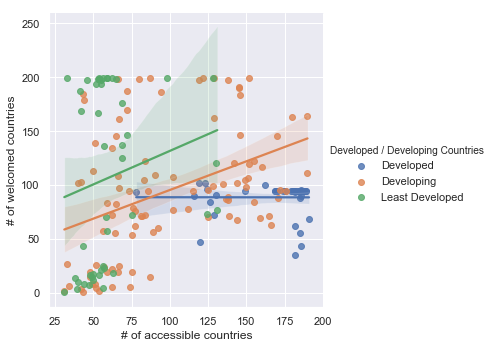

In [90]:
sns.set()

# Plot sepal with as a function of sepal_length across days
g = sns.lmplot(x="visafree", y="visafreeTO", hue="Developed / Developing Countries",
               truncate=True, height=5, data=df_pivot_flattened)

# Use more informative axis labels than are provided by default
g.set_axis_labels("# of accessible countries", "# of welcomed countries")

## Heatmap visualization of the access of Unesco World heritage sites per country passport

In [92]:
data = [ dict(
        type = 'choropleth',
        locations = df_pivot_flattened['country_alpha_3code'],
        z = df_pivot_flattened['unesco_total_sites'],
        text = df_pivot_flattened['passportfrom_Country_name'],
#         colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
#             [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = True,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            #tickprefix = '',
            title = 'number of Unesco sites accessible'),
      ) ]

layout = dict(
    title = 'Access of Unesco World heritage sites per country passport',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='passports-world-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jeremielamboley/0 or inside your plot.ly account where it is named 'passports-world-map'


C:\Users\Jrmy\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

